In [4]:
from concurrent.futures import as_completed, ProcessPoolExecutor
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from skimage.morphology import label
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import measurements

In [ ]:
# example grid
grid5 = np.array([
    [0, -1, -1, -1, -1],
    [-1, -1, 9, -1, 7],
    [8, -1, -1, -1, -1],
    [-1, -1, 15, -1, 12],
    [10, -1, -1, -1, -1],
])

# made up 6x6 grid
grid6 = np.array([
    [-1, -1, 11, -1, -1, 0],
    [-1, 10, -1, -1, 5, -1],
    [-1, -1, -1, 13, -1, -1],
    [-1, -1, -1, -1, -1, -1],
    [-1, 7, -1, -1, 20, -1],
    [-1, -1, 2, -1, -1, -1],
])

# actual puzzle
grid9 = np.array([
    [-1, 18, -1, -1, -1, -1, 7, -1, -1],
    [-1, -1, -1, -1, 12, -1, -1, -1, -1],
    [-1, -1, 9, -1, -1, -1, -1, 31, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 5, -1, 11, -1, 22, -1, 22, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 9, -1, -1, -1, -1, 19, -1, -1],
    [-1, -1, -1, -1, 14, -1, -1, -1, -1],
    [-1, -1, 22, -1, -1, -1, -1, 15, -1],
])

In [5]:

def check_connectivity(grid, pad=False):
    if pad:
        padded_grid = np.where(grid < 0, 10, grid)
        return np.max(label(padded_grid > 0, connectivity=1)) <= 1
    return np.max(label(grid > 0, connectivity=1)) <= 1

def hint_checker(grid, solution):
    # pad the grid to allow for easier indexing
    pgrid = np.pad(grid, 1, mode="constant", constant_values=-5)
    hints = np.where(
        pgrid >= 0)
    padded_grid = np.pad(solution, 1, mode="constant", constant_values=-5)
    orth = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])
    for hint in zip(*hints):
        i, j = hint
        total = pgrid[i, j]
        incomplete = 0
        for o in orth:
            x, y = o
            if padded_grid[i+x, j+y] >= 0:
                total -= padded_grid[i+x, j+y]
            elif padded_grid[i+x, j+y] != -5:
                incomplete += 1
        # if surrounding not complete, make sure its not over total
        if incomplete > 0 and total < 0:
            return False
        # if complete, must be exact
        if incomplete == 0 and total != 0:
            return False

    return True


def check_2x2(grid):
    grid_size = len(grid[0])
    for i in range(grid_size-2):
        for j in range(grid_size-2):
            if grid[i, j] > 0 and grid[i+1, j] > 0 and grid[i, j+1] > 0 and grid[i+1, j+1] > 0:
                return False
    return True


def make_solution(grid, solution, hook_size, completed_hooks=[1]):
    grid_size = len(grid[0])
    available_corners = []
    top_left = [0, 0]
    f = False
    for i in range(grid_size):
        for j in range(grid_size):
            if solution[i, j] >= 0:
                top_left = [i-1, j-1]
                f = True
                break
        if f:
            break
    if all(n >= 0 for n in top_left):
        available_corners.append(top_left)

    if (top_left[0] + hook_size < grid_size) and top_left[1] >= 0:
        available_corners.append([top_left[0] + hook_size, top_left[1]])
    if (top_left[1] + hook_size < grid_size) and top_left[0] >= 0:
        available_corners.append([top_left[0], top_left[1] + hook_size])
    if (top_left[1] + hook_size < grid_size) and (top_left[0] + hook_size < grid_size):
        available_corners.append(
            [top_left[0] + hook_size, top_left[1] + hook_size])
    new_solution = solution.copy()

    if len(available_corners) == 0:
        print("No available corners")
        return
    for corner in available_corners:

        if corner[1] > top_left[1]:
            row = new_solution[corner[0]][corner[1]-hook_size+1: corner[1]]
            row_idxs = [corner[0], corner[0]+1,
                        corner[1]-hook_size+1, corner[1]]
        else:
            row = new_solution[corner[0]][corner[1]+1:corner[1]+hook_size]
            row_idxs = [corner[0], corner[0]+1,
                        corner[1]+1, corner[1]+hook_size]

        if corner[0] > top_left[0]:
            col = new_solution[(corner[0]-hook_size) +
                                1:corner[0]+1][:, corner[1]]
            col_idxs = [(corner[0]-hook_size)+1, corner[0] +
                        1, corner[1], corner[1]+1]
        else:
            col = new_solution[corner[0]:corner[0]+hook_size][:, corner[1]]
            col_idxs = [corner[0], corner[0] +
                        hook_size, corner[1], corner[1]+1]

        cells = np.concatenate([col, row])
        col_spaces = np.where(col == -1, 1, 0).sum()
        row_spaces = np.where(row == -1, 1, 0).sum()
        available_cells = col_spaces+row_spaces

        if available_cells == 0:
            print(
                f"Dropping corner {corner} as there are no available cells")
            break

        available_hook_numbers = [n for n in range(
            1, grid_size+1) if n not in completed_hooks and n <= available_cells]

        if len(available_hook_numbers) == 0:

            break

        for num in available_hook_numbers:

            combs = list(combinations(
                [i for i, item in enumerate(cells) if item == -1], num))
            for comb in combs:
                col_idx = [n for n in comb if n < len(col)]
                row_idx = [n - len(col) for n in comb if n >= len(col)]

                next_solution = new_solution.copy()

                col_z = [n for n in range(len(col)) if n not in col_idx]
                row_z = [n for n in range(len(row)) if n not in row_idx]
                next_solution[row_idxs[0]: row_idxs[1],
                                row_idxs[2]:row_idxs[3]][:, row_idx] = num
                next_solution[row_idxs[0]: row_idxs[1],
                                row_idxs[2]:row_idxs[3]][:, row_z] = 0
                next_solution[col_idxs[0]: col_idxs[1],
                                col_idxs[2]:col_idxs[3]][col_idx, :] = num
                next_solution[col_idxs[0]: col_idxs[1],
                                col_idxs[2]:col_idxs[3]][col_z, :] = 0
                
                if hook_size == grid_size:
                    if hint_checker(grid, next_solution) and check_connectivity(next_solution) and check_2x2(next_solution):
                        yield next_solution
                else:

                    if hint_checker(grid, next_solution) and check_connectivity(next_solution, True) and check_2x2(next_solution):

                        yield from make_solution(grid, next_solution, hook_size+1, [*completed_hooks, num])


def pprint(matrix):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    x = np.array((matrix).astype('int').astype('str'))
    crest_cmap = sns.color_palette("crest", as_cmap=True)
    x[x==0] = ''
    ax = sns.heatmap(matrix, mask=matrix == 0, cbar=False, fmt="", cmap="crest", annot=x, linewidths="0.5")
    ax.axis("off")


def areas(grid):
    labels, num = measurements.label(np.logical_not(grid != 0))
    areas = measurements.sum(np.logical_not(
        grid >= 1), labels, index=range(1, num+1))
    return np.prod(areas)

 97%|█████████▋| 65/67 [05:08<00:09,  4.74s/it]



Found solution.


Area: 8400.0 



/tmp/ipykernel_204267/2476847390.py:190: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  labels, num = measurements.label(np.logical_not(grid != 0))
/tmp/ipykernel_204267/2476847390.py:191: DeprecationWarning: Please import `sum` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  areas = measurements.sum(np.logical_not(


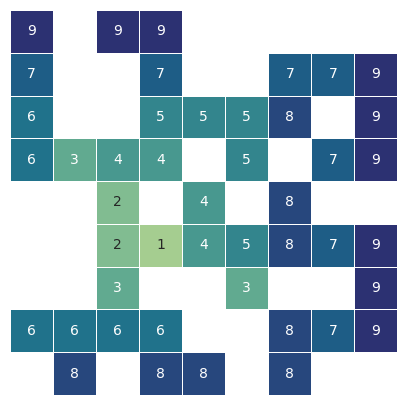

In [6]:
grid = grid9
grid_size = len(grid[0])

def task(grid, s, n):
    return list(make_solution(grid, s, n))

with ProcessPoolExecutor(max_workers=24) as pool:
    counter = 0
    solution = None
    sol = np.where(grid != -1, -2, -1)
    futures = []
    for i in range(grid_size-1, -1, -1):
        for j in range(grid_size-1, -1, -1):
            if grid[i, j] != -1:
                continue
            s = sol.copy()
            s[i, j] = 1
            futures.append(pool.submit(task, grid, s, 2))
    with tqdm(total=grid_size**2-len(grid[grid>=0])) as pbar:
        for f in as_completed(futures):
            counter += 1
            r = f.result()
            if r:
                solution = r[0]
                break
            pbar.update(1)

if solution is not None:
    print("\nFound solution.\n")
    pprint(solution)
    print("\nArea:", areas(solution), "\n")
else:
    print("\nNo solution found.\n")